In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-energy-behavior-of-prosumers/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv
/kaggle/input/predict-energy-behavior-of-prosumers/public_timeseries_testing_util.py
/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json
/kaggle/input/predict-energy-behavior-of-prosumers/train.csv
/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity

In [2]:
gas_prices = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv")
# Seeing that the relation between origin and forecast is always one day
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])
gas_prices['origin_date'] = pd.to_datetime(gas_prices['origin_date'])
gas_prices['data_block_id'] = (gas_prices['forecast_date'] - gas_prices['forecast_date'].min()).dt.days + 1
gas_prices = gas_prices.drop(columns='origin_date')

# Doing log because they are skewed toward 0
gas_prices['mean_price_per_mwh'] = (gas_prices['lowest_price_per_mwh'] + gas_prices['highest_price_per_mwh']) / 2
gas_prices['variation_price_per_mwh'] = (- gas_prices['lowest_price_per_mwh'] + gas_prices['highest_price_per_mwh']) / 2
gas_prices['log_mean_price_per_mwh'] = np.log(gas_prices['mean_price_per_mwh'])
gas_prices['log_variation_price_per_mwh'] = np.log(gas_prices['variation_price_per_mwh'])
gas_prices = gas_prices.drop(columns=['lowest_price_per_mwh', 'highest_price_per_mwh', 'forecast_date'])

# print(gas_prices.info())

# sample = gas_prices
# for col in sample.columns:
#     plt.figure(figsize=(10,4))
#     # Different plotting based on data type
#     if sample[col].dtype == 'object' or len(sample[col].unique()) < 10:
#         # For categorical or discrete numerical data
#         sns.countplot(x=col, data=sample)
#     else:
#         # For continuous numerical data
#         sns.histplot(sample[col], kde=True)
#     plt.title(f'Distribution of {col}')

In [3]:
electricity_prices = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv")
electricity_prices = electricity_prices.dropna()

electricity_prices['log_euros_per_mwh'] = np.log(electricity_prices['euros_per_mwh'] - np.min(electricity_prices['euros_per_mwh']) + 0.01) # log to avoid skewness
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices['data_block_id'] = (electricity_prices['forecast_date'] - electricity_prices['forecast_date'].min()).dt.days + 1

electricity_prices = electricity_prices.groupby('data_block_id').agg({
    'euros_per_mwh':["max", "min"],
    'forecast_date' :'first'
}).reset_index()
electricity_prices.columns = ['data_block_id', 'highest_price_per_mwh', 'lowest_price_per_mwh', 'forecast_date']

# Doing log because they are skewed toward 0
electricity_prices['mean_price_per_mwh'] = (electricity_prices['lowest_price_per_mwh'] + electricity_prices['highest_price_per_mwh']) / 2
electricity_prices['variation_price_per_mwh'] = (- electricity_prices['lowest_price_per_mwh'] + electricity_prices['highest_price_per_mwh']) / 2
electricity_prices['log_mean_price_per_mwh'] = np.log(electricity_prices['mean_price_per_mwh'])
electricity_prices['log_variation_price_per_mwh'] = np.log(electricity_prices['variation_price_per_mwh'])
electricity_prices = electricity_prices.drop(columns=['lowest_price_per_mwh', 'highest_price_per_mwh'])

# Generating features to capture seasonality
electricity_prices['year'] = electricity_prices['forecast_date'].dt.year
electricity_prices['month'] = electricity_prices['forecast_date'].dt.month
electricity_prices['quarter'] = electricity_prices['forecast_date'].dt.quarter
electricity_prices['week_of_year'] = electricity_prices['forecast_date'].dt.isocalendar().week.astype('int32')
electricity_prices['day_of_week'] = electricity_prices['forecast_date'].dt.dayofweek
electricity_prices['is_weekend'] = electricity_prices['day_of_week'].apply(lambda x: 1 if x > 4 else 0)
electricity_prices = electricity_prices.drop(columns=['forecast_date'])  # dropping data_block_id because more info (hours) is in forecast_date, and dropping origin date like in gas_prices
# print(electricity_prices.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   county_name  49 non-null     object 
 1   longitude    112 non-null    float64
 2   latitude     112 non-null    float64
 3   county       49 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.6+ KB


Text(0, 0.5, 'Latitude')

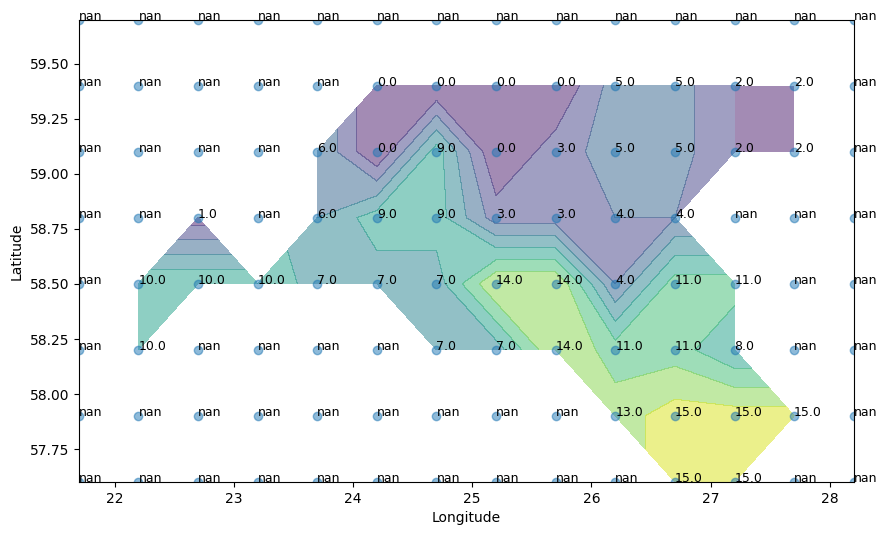

In [4]:
weather_station_to_county_mapping = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv")
weather_station_to_county_mapping.info()

df = weather_station_to_county_mapping
plt.figure(figsize=(10, 6))
x = df.longitude.value_counts().keys()
y = df.latitude.value_counts().keys()
Y, X = np.meshgrid(y, x)
# Assign each grid point a label
Z = np.zeros(X.shape)
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j] = df.loc[(df['longitude'] == x[i]) & (df['latitude'] == y[j]), 'county'].values[0]

plt.contourf(X, Y, Z, alpha=0.5)
plt.scatter(df['longitude'], df['latitude'], alpha=0.5)
for i, row in df.iterrows():
    plt.text(row['longitude'], row['latitude'], row['county'], fontsize=9)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [5]:
from sklearn.mixture import GaussianMixture

forecast_weather = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv")
forecast_weather = forecast_weather.dropna()

# Rounding to avoid floating point differences that lead to not being able to merge them
forecast_weather['longitude'] = forecast_weather['longitude'].round(1)
forecast_weather['latitude'] = forecast_weather['latitude'].round(1)
weather_station_to_county_mapping['longitude'] = weather_station_to_county_mapping['longitude'].round(1)
weather_station_to_county_mapping['latitude'] = weather_station_to_county_mapping['latitude'].round(1)

forecast_weather = forecast_weather.merge(weather_station_to_county_mapping, on=['latitude','longitude'], how='left')
forecast_weather = forecast_weather.drop(columns=['origin_datetime','latitude','longitude','county_name', 'forecast_datetime', 'hours_ahead'])
# Because counties expand across different combinations of latitude and longitude, we take the mean value of the weather columns in the county
forecast_weather = forecast_weather.groupby(['data_block_id', 'county']).mean().reset_index()
forecast_weather['county'] = forecast_weather['county'].astype(int)

# feature for if it has snowed
forecast_weather['log_snowfall'] = forecast_weather['snowfall'].apply(lambda x: np.log(x + 1e-5))
forecast_weather['log_total_precipitation'] = forecast_weather['total_precipitation'].apply(lambda x: np.log(x + 1e-5))

In [6]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

train = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/train.csv")
test = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/test.csv")

train = train.dropna()
test = test.dropna()

train['data_block_id'] = train['data_block_id'].replace(to_replace=0, value=1)  # Because the prices do not have data for day 0, basically we are imputing with the values from the following day
test['data_block_id'] = test['data_block_id'].replace(to_replace=0, value=1)

print("Train shape before: ", train.shape)
print("Test shape before: ", test.shape)
train = train.drop(columns='datetime')

train = train.merge(forecast_weather, on=['data_block_id', 'county'], how='left')  # Merge with weather conditions
train_impute = train   # for the last cell
test = test.merge(forecast_weather, on=['data_block_id', 'county'], how='left') 

# Merging produces nans (missing county 12) and converts some ints to float (because of the NaNs). Lets KNN impute them, so that idealy it generates similar climate conditions
columns_impute = forecast_weather.columns[2:]
train = train.fillna(train.median())
test = test.fillna(train.median())

# Gaussian mixtures for temperature and dewpoint, because
gmm = GaussianMixture(n_components=4)
feats_gm = ['temperature', 'dewpoint']
for feat in feats_gm:
    gmm.fit(train[feat].values.reshape(-1,1))
    train[f'{feat}_gm'] = gmm.predict(train[feat].values.reshape(-1,1))
    test[f'{feat}_gm'] = gmm.predict(test[feat].values.reshape(-1,1))

train['is_snow'] = train['snowfall'].apply(lambda x: 1 if x > 0. else 0)
train['is_preciptation'] = train['total_precipitation'].apply(lambda x: 1 if x > 0. else 0)
test['is_snow'] = test['snowfall'].apply(lambda x: 1 if x > 0. else 0)
test['is_preciptation'] = test['total_precipitation'].apply(lambda x: 1 if x > 0. else 0)

train = train.merge(gas_prices, on=['data_block_id'], how='left')  # Merge with gas prices
test = test.merge(gas_prices, on=['data_block_id'], how='left')

train = train.merge(electricity_prices, on=['data_block_id'], how='left')  # Merge with electricity prices
test = test.merge(electricity_prices, on=['data_block_id'], how='left')

print("Train shape after: ", train.shape)
print("Test shape after: ", test.shape)

Train shape before:  (2017824, 9)
Test shape before:  (12480, 9)
Train shape after:  (2017824, 40)
Test shape after:  (12480, 41)


In [7]:
# sample = train
# for col in sample.columns:
#     plt.figure(figsize=(10,4))
#     # Different plotting based on data type
#     if sample[col].dtype == 'object' or len(sample[col].unique()) < 20:
#         # For categorical or discrete numerical data
#         sns.countplot(x=col, data=sample)
#     else:
#         # For continuous numerical data
#         sns.histplot(sample[col], kde=True)
#     plt.title(f'Distribution of {col}')

In [8]:
# # Let's check out correlations
# plt.figure(figsize=(24,20))
# sns.heatmap(train.select_dtypes(['int64','float64']).corr(),annot=True)

In [9]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
norm_features = [col for col in test.columns if test[col].dtype == 'float64']
transformer = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), norm_features)
    ],
    remainder='passthrough'
)

X = train.drop(columns=['target','row_id'])
y = train.target
X = transformer.fit_transform(X)

# Transform the target for the train test too
target_scaler = RobustScaler()
y = target_scaler.fit_transform(y.to_frame())


In [10]:
import optuna
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def objective(trial):
    params = {
        'objective': 'reg:linear',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 0.5),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0.5, 1.0),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0.5, 1.0),
        'random_state': 42
    }
    
    xgb_regressor = xgb.XGBRegressor(**params)
    
    skfold = KFold(n_splits=3, shuffle=True)
    cv_results = []
    for fold, (train_idx, val_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        xgb_trained = xgb_regressor.fit(X_train, y_train)
        y_val_pred = xgb_trained.predict(X_val)
        val_loss = mean_absolute_error(y_val_pred, y_val)
        cv_results.append(val_loss)
    return np.mean(cv_results)

# tuning_study = optuna.create_study(direction="minimize")
# tuning_study.optimize(objective, n_trials=5)

# print("Best trial:")
# trial = tuning_study.best_trial
# print(f"  Value: {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# best_params = tuning_study.best_params
# best_xgb = xgb.XGBRegressor(**best_params)

In [11]:
# Best params:
best_params = {'learning_rate': 0.44932043296160135, 'n_estimators': 563, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.8741869607320512, 'colsample_bytree': 0.4457538874924199, 'reg_alpha': 0.5232570881012439, 'reg_lambda': 0.7600224198232657}
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X, y)
# best_xgb.save_model('best_xgb.json')
# best_xgb.load_model('best_xgb.json')

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4457538874924199, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.44932043296160135, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=563, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
submission = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv")

# test = test.drop(columns=['currently_scored'])
submission['data_block_id'] = test['data_block_id'].values

test_scaled = transformer.transform(test)
y_test_pred = best_xgb.predict(test_scaled)
submission['target'] = target_scaler.inverse_transform(y_test_pred.reshape(-1,1))
# submission.to_csv('submission.csv', index=False)


In [13]:
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

In [14]:
for (
    test, 
    df_new_target, 
    df_new_client, 
    historical_weather,
    forecast_weather, 
    electricity_prices, 
    gas_prices,
    sample_prediction
) in iter_test:
    print(sample_prediction.target.describe())
    
    # Seeing that the relation between origin and forecast is always one day
    gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])
    gas_prices['origin_date'] = pd.to_datetime(gas_prices['origin_date'])
    gas_prices['data_block_id'] = (gas_prices['forecast_date'] - gas_prices['forecast_date'].min()).dt.days + 1
    gas_prices = gas_prices.drop(columns='origin_date')

    # Doing log because they are skewed toward 0
    gas_prices['mean_price_per_mwh'] = (gas_prices['lowest_price_per_mwh'] + gas_prices['highest_price_per_mwh']) / 2
    gas_prices['variation_price_per_mwh'] = (- gas_prices['lowest_price_per_mwh'] + gas_prices['highest_price_per_mwh']) / 2
    gas_prices['log_mean_price_per_mwh'] = np.log(gas_prices['mean_price_per_mwh'])
    gas_prices['log_variation_price_per_mwh'] = np.log(gas_prices['variation_price_per_mwh'])
    gas_prices = gas_prices.drop(columns=['lowest_price_per_mwh', 'highest_price_per_mwh', 'forecast_date'])
    
    electricity_prices = electricity_prices.dropna()
    electricity_prices['log_euros_per_mwh'] = np.log(electricity_prices['euros_per_mwh'] - np.min(electricity_prices['euros_per_mwh']) + 0.01) # log to avoid skewness
    electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
    electricity_prices['data_block_id'] = (electricity_prices['forecast_date'] - electricity_prices['forecast_date'].min()).dt.days + 1

    electricity_prices = electricity_prices.groupby('data_block_id').agg({
        'euros_per_mwh':["max", "min"],
        'forecast_date' :'first'
    }).reset_index()
    electricity_prices.columns = ['data_block_id', 'highest_price_per_mwh', 'lowest_price_per_mwh', 'forecast_date']

    # Doing log because they are skewed toward 0
    electricity_prices['mean_price_per_mwh'] = (electricity_prices['lowest_price_per_mwh'] + electricity_prices['highest_price_per_mwh']) / 2
    electricity_prices['variation_price_per_mwh'] = (- electricity_prices['lowest_price_per_mwh'] + electricity_prices['highest_price_per_mwh']) / 2
    electricity_prices['log_mean_price_per_mwh'] = np.log(electricity_prices['mean_price_per_mwh'])
    electricity_prices['log_variation_price_per_mwh'] = np.log(electricity_prices['variation_price_per_mwh'])
    electricity_prices = electricity_prices.drop(columns=['lowest_price_per_mwh', 'highest_price_per_mwh'])

    # Generating features to capture seasonality
    electricity_prices['year'] = electricity_prices['forecast_date'].dt.year
    electricity_prices['month'] = electricity_prices['forecast_date'].dt.month
    electricity_prices['quarter'] = electricity_prices['forecast_date'].dt.quarter
    electricity_prices['week_of_year'] = electricity_prices['forecast_date'].dt.isocalendar().week.astype('int32')
    electricity_prices['day_of_week'] = electricity_prices['forecast_date'].dt.dayofweek
    electricity_prices['is_weekend'] = electricity_prices['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

    forecast_weather = forecast_weather.dropna()
    # Rounding to avoid floating point differences that lead to not being able to merge them
    forecast_weather['longitude'] = forecast_weather['longitude'].round(1)
    forecast_weather['latitude'] = forecast_weather['latitude'].round(1)
    weather_station_to_county_mapping['longitude'] = weather_station_to_county_mapping['longitude'].round(1)
    weather_station_to_county_mapping['latitude'] = weather_station_to_county_mapping['latitude'].round(1)

    forecast_weather = forecast_weather.merge(weather_station_to_county_mapping, on=['latitude','longitude'], how='left')
    forecast_weather['forecast_datetime'] = pd.to_datetime(forecast_weather['forecast_datetime'])
    forecast_weather['data_block_id'] = (forecast_weather['forecast_datetime'] - forecast_weather['forecast_datetime'].min()).dt.days
    forecast_weather = forecast_weather.drop(columns=['origin_datetime','latitude','longitude','county_name', 'forecast_datetime', 'hours_ahead'])
    # Because counties expand across different combinations of latitude and longitude, we take the mean value of the weather columns in the county
    forecast_weather = forecast_weather.groupby(['data_block_id', 'county']).mean().reset_index()
    forecast_weather['county'] = forecast_weather['county'].astype(int)

    # feature for if it has snowed
    forecast_weather['log_snowfall'] = forecast_weather['snowfall'].apply(lambda x: np.log(x + 1e-5))
    forecast_weather['log_total_precipitation'] = forecast_weather['total_precipitation'].apply(lambda x: np.log(x + 1e-5))
    
    test['prediction_datetime'] = pd.to_datetime(test['prediction_datetime'])
    test['data_block_id'] = (test['prediction_datetime'] - electricity_prices['forecast_date'].min()).dt.days
    test['data_block_id'] = test['data_block_id'].replace(to_replace=0, value=1)
    test = test.merge(forecast_weather, on=['data_block_id', 'county'], how='left') 
    electricity_prices = electricity_prices.drop(columns=['forecast_date'])  # dropping data_block_id because more info (hours) is in forecast_date, and dropping origin date like in gas_prices

    columns_impute = forecast_weather.columns[2:]
    test = test.fillna(train_impute.median())
    feats_gm = ['temperature', 'dewpoint']
    for feat in feats_gm:
        test[f'{feat}_gm'] = gmm.predict(test[feat].values.reshape(-1,1))
    test['is_snow'] = test['snowfall'].apply(lambda x: 1 if x > 0. else 0)
    test['is_preciptation'] = test['total_precipitation'].apply(lambda x: 1 if x > 0. else 0)

    test = test.merge(gas_prices, on=['data_block_id'], how='left')
    test = test.merge(electricity_prices, on=['data_block_id'], how='left')
    norm_features = [col for col in test.columns if test[col].dtype == 'float64']

    test_scaled = transformer.transform(test)
    y_test_pred = best_xgb.predict(test_scaled)
    sample_prediction['target'] = 0.0#target_scaler.inverse_transform(y_test_pred.reshape(-1,1)).astype('float64').clip(0.0)
    env.predict(sample_prediction)
    

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
count    3120.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: target, dtype: float64
count    3120.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: target, dtype: float64
count    3120.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: target, dtype: float64
count    3120.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: target, dtype: float64
